<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Loading" data-toc-modified-id="Loading-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Exploration" data-toc-modified-id="Exploration-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Exploration</a></span></li></ul></li><li><span><a href="#Seat-Allocations" data-toc-modified-id="Seat-Allocations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Seat Allocations</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Shifts-in-Representation" data-toc-modified-id="Shifts-in-Representation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Shifts in Representation</a></span></li><li><span><a href="#Effects-on-Presidential-Representation" data-toc-modified-id="Effects-on-Presidential-Representation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Effects on Presidential Representation</a></span></li><li><span><a href="#Disproportionality" data-toc-modified-id="Disproportionality-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Disproportionality</a></span></li></ul></li></ul></div>

**US HoR Seat Allocation**

This example uses Wikidata statistics sourced by [wikirepo](https://github.com/andrewtavis/wikirepo) as a basis for the allocation and analysis of seats to states in the US House of Representatives given populations at different times. The Huntington-Hill method of apportionment will be used - the method used by the US HoR for seat allocation. Analysis will look at seat allocations over time, how seats are likely to change given recent population shifts, and further show how HoR allocations affect representation in the US presidential election via Electoral College vote assignment.

To assure that all US citizens (nationals in the case of American Samoa) are represented:
- Puerto Rico and the US Virgin Islands will be considered as a single state
    - Abbreviated as "Puerto Rico and USVI" for plotting purposes

- American Samoa, Guam, the Northern Mariana Islands, and the United States Minor Outlying Islands will be combined to form Pacific Island States
    - This new state is the least populous in the hypothetical union
    
- Washington DC will be considered as a state

This notebook can also be opened in [Google Colab](https://colab.research.google.com/github/andrewtavis/poli-sci-kit/blob/main/examples/us_house_of_rep.ipynb).

In [ ]:
# pip install poli-sci-kit

In [ ]:
# pip install pltviz

In [ ]:
# pip install wikirepo

In [1]:
# To avoid exceeding your IOPub rate, you made need to load Jupyter via:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

import numpy as np
import pandas as pd
from datetime import date

import wikirepo
from wikirepo.data import data_utils, lctn_utils, wd_utils

from poli_sci_kit import appointment
from poli_sci_kit import utils

import pltviz
from pltviz.utils import add_num_commas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15,5)})

import logging
logging.getLogger().setLevel(logging.CRITICAL) # to disable alerts about empty legend handles 

pd.set_option("display.max_rows", 16)
pd.set_option('display.max_columns', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

# Data Preparation

## Loading

We'll be querying population statistics for states between 1960 and the current date, as 1959 was the year that Alaska and Hawaii became the 49th and 50th states.

**Note:** the `sub_lctns` argument can be used to either select locations that we do want (deselecting all others), or indicate those that we don't want. Passing strings selects them, and strings with `~` as the first character negates their selection. We're negating the District of Columbia, as we'll be using the data from Washington DC instead.

For this example we're querying US state information, so we'll be using `depth = 1`. For counties in the US we'd use `depth = 2`. 

The following are the needed variables for our social-sci-kit import:

In [2]:
ents_dict = wd_utils.EntitiesDict()
depth = 1
country = 'United States of America'
# country = 'Q30' # we could also pass its QID
sub_lctns = '~District of Columbia'
interval = 'yearly'
timespan = (date(1960,1,1), date.today())

Now let's load in a locations dictionary of the states and territories, checking what we've queried afterwards:

In [3]:
lctns_dict = lctn_utils.gen_lctns_dict(ents_dict=ents_dict,
                                       depth=depth,
                                       locations=country, 
                                       sub_lctns=sub_lctns,
                                       timespan=timespan,
                                       interval=interval, 
                                       verbose=False) # False for web display

In [4]:
print(*sorted(lctns_dict.key_lbls_at_depth(ents_dict=ents_dict, depth=1)), sep=', ')

Alabama, Alaska, American Samoa, Arizona, Arkansas, California, Colorado, Connecticut, Delaware, Florida, Georgia, Guam, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New Hampshire, New Jersey, New Mexico, New York, North Carolina, North Dakota, Northern Mariana Islands, Ohio, Oklahoma, Oregon, Pennsylvania, Puerto Rico, Rhode Island, South Carolina, South Dakota, Tennessee, Texas, United States Minor Outlying Islands, United States Virgin Islands, Utah, Vermont, Virginia, Washington, Washington, D.C., West Virginia, Wisconsin, Wyoming


From here we use `lctns_dict` as the value for `locations` in `social_sci_kit.data.query` for state population data:

In [5]:
df = wikirepo.data.query(ents_dict=ents_dict,
                         depth=depth, locations=lctns_dict,
                         timespan=timespan, interval=interval,
                         climate_props=None,
                         demographic_props='population', 
                         economic_props=None, 
                         electoral_poll_props=None, 
                         electoral_result_props=None,
                         geographic_props=None, 
                         institutional_props=None,
                         political_props=None,
                         misc_props=None,
                         verbose=False) # False for web display

In [6]:
df_states = df.copy()

Next we'll subset by decennial census years and include the 2015 estimate. Afterwards we'll interpolate any values that are missing using `data_utils.interp_by_subset`, which takes arguments from [pandas.DataFrame.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) and [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html) and applies them to a dataframe subsetted by a given depth column (`sub_lctn` in this case). The values of the resulting columns will then be converted to integers:

In [7]:
decades_and_2015 = ['1960', '1970', '1980', '1990', '2000', '2010', '2015']
df_states = df_states[df_states['year'].isin(decades_and_2015)]

df_states = data_utils.interp_by_subset(df=df_states, 
                                        depth=1, 
                                        col_name='population', 
                                        method='slinear', 
                                        fill_value='extrapolate', 
                                        limit_direction='both')

df_states['population'] = df_states['population'].astype(int)
df_states.reset_index(drop=True, inplace=True)

In [8]:
df_states[df_states['sub_lctn'] == 'California']

,location,sub_lctn,qid,year,population
14,United States of America,California,Q99,2015,39144818
15,United States of America,California,Q99,2010,37253956
16,United States of America,California,Q99,2000,33871648
17,United States of America,California,Q99,1990,29760021
18,United States of America,California,Q99,1980,23667902
19,United States of America,California,Q99,1970,19953134
20,United States of America,California,Q99,1960,15717204


## Preprocessing

Let's combine populations and rename the regions as we discussed in the introduction:

In [9]:
df_new_states = data_utils.sum_df_prop_vals(df=df_states,
                                            target_lctn='Puerto Rico', 
                                            vals_lctn='United States Virgin Islands', 
                                            lctn_col='sub_lctn', 
                                            time_col='year',
                                            prop_col='population',
                                            subtract=False,
                                            drop_vals_lctn=True)

df_new_states = data_utils.sum_df_prop_vals(df=df_new_states,
                                            target_lctn='American Samoa', 
                                            vals_lctn='Guam', 
                                            lctn_col='sub_lctn', 
                                            time_col='year',
                                            prop_col='population',
                                            subtract=False,
                                            drop_vals_lctn=True)

df_new_states = data_utils.sum_df_prop_vals(df=df_new_states,
                                            target_lctn='American Samoa', 
                                            vals_lctn='Northern Mariana Islands', 
                                            lctn_col='sub_lctn', 
                                            time_col='year',
                                            prop_col='population',
                                            subtract=False,
                                            drop_vals_lctn=True)

df_new_states = data_utils.sum_df_prop_vals(df=df_new_states,
                                            target_lctn='American Samoa', 
                                            vals_lctn='United States Minor Outlying Islands', 
                                            lctn_col='sub_lctn', 
                                            time_col='year',
                                            prop_col='population',
                                            subtract=False,
                                            drop_vals_lctn=True)

In [10]:
df_new_states['sub_lctn'] = df_new_states['sub_lctn'].replace("Puerto Rico", "Puerto Rico and USVI")
df_new_states['sub_lctn'] = df_new_states['sub_lctn'].replace("American Samoa", "Pacific Island States")

In [11]:
len(df_new_states['sub_lctn'].unique())

53

## Exploration

Here's a bar plot of the 2015 populations in `df_new_states`:

In [12]:
df_2015_pops = df_new_states[df_new_states['year'] == '2015']
df_2015_pops = df_2015_pops.sort_values(by=['population'], ascending=False)
df_2015_pops.reset_index(drop=True, inplace=True)

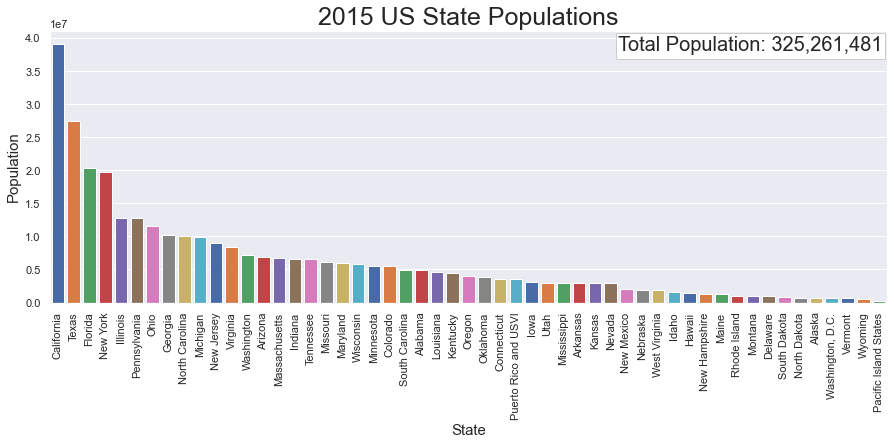

In [13]:
ax = pltviz.bar(counts=df_2015_pops['population'], 
                labels=df_2015_pops['sub_lctn'], 
                faction_labels=None, 
                colors=None, 
                horizontal=False, 
                stacked=False, 
                label_bars=False, 
                axis=None)

# Initialize empty handles and labels
handles, labels = pltviz.legend.gen_elements()

ax.legend(handles=handles, labels=labels,
          title='Total Population: {}'.format(add_num_commas(sum(df_2015_pops['population']))), 
          bbox_to_anchor=(1, 1),
          title_fontsize=20, fontsize=5, 
          ncol=2, loc='upper right', 
          frameon=True, facecolor='#ffffff', framealpha=1)

ax.axes.set_title('2015 US State Populations', fontsize=25)
ax.set_ylabel('Population', fontsize=15)
ax.set_xticklabels(labels=df_2015_pops['sub_lctn'], rotation=90)
ax.set_xlabel('State', fontsize=15)

plt.show()

And here's how the populations of a few select states have changed over time:

In [14]:
selected_states = ['California', 'Georgia', 'Hawaii', 'Michigan', 'New York', 'Oregon', 'Texas', 'Wyoming']
df_selected = df_new_states[df_new_states['sub_lctn'].isin(selected_states)]

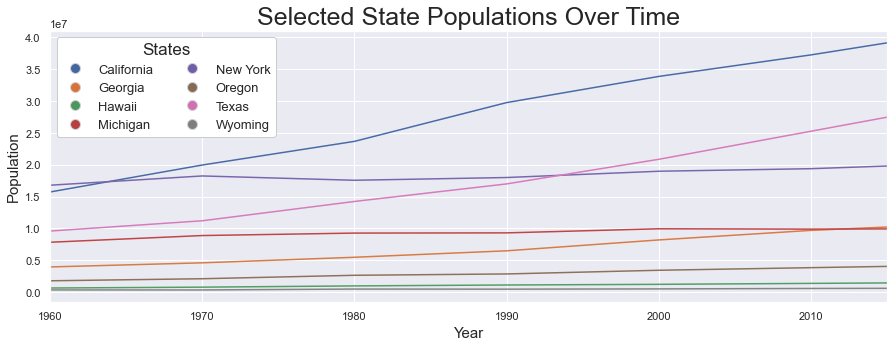

In [15]:
ax = pltviz.comp_line(df=df_selected, 
                      dependent_cols='population', 
                      indep_stats='year',
                      group_col='sub_lctn')

colors = [utils.rgb_to_hex(c) for c in sns.color_palette(n_colors=len(selected_states), desat=1)]
handles = pltviz.legend.gen_handles(colors=colors, size=10, marker='o')
labels = list(df_selected['sub_lctn'].unique())

ax.legend(handles=handles, labels=labels, 
          title='States',
          bbox_to_anchor=(0, 1),
          ncol=2, loc='upper left', fontsize=13, 
          title_fontsize=17, 
          frameon=True, facecolor='#ffffff', framealpha=1)

ax.axes.set_title('Selected State Populations Over Time', fontsize=25)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Population', fontsize=15)

plt.show()

# Seat Allocations

This example will maintain 435 as the total number of seats in the House of Representatives. As stated before, we'll also be using [Huntington-Hill](https://en.wikipedia.org/wiki/Huntington%E2%80%93Hill_method) method for apportionment in this example, which is the same method used as the US House of Representatives for determining the number of seats per state given populations. It is a version of highest average apportionment, where in this case the populations of each state are iteratively divided by a uniquely determined denominator that is derived from the number of seats each state has already received. In comparison to other highest average methods, the Huntington-Hill method generally favors smaller groups more. 

Each state starts with one seat, and the next seat is given to the state that has the highest quotient after division. The divisor $D_{si}$ for a state $s$ at any given iteration $i$ given its population $P_s$ and current seat allocation $a_{si}$ is:

$$D_{si} = \frac{P_s}{\sqrt{a_{si}(a_{si} + 1)}}$$

Whichever state $s$ that has the highest value $D_{si}$ gets the next seat to be allocated, and then the divisors are calculated again for all states given the newest allocation.

We'll now define the seat total and add a column to `df_new_states` for apportionments for the given years:

In [16]:
total_seats = 435
df_new_states['hor_allocation'] = [np.nan] * len(df_new_states)

Populations in `df_new_states` will now be subsetted by year, and the HoR seats will be allocated:

In [17]:
for y in decades_and_2015:
    df_new_states.loc[df_new_states.loc[df_new_states['year'] == y].index, 'hor_allocation'] = \
        appointment.methods.highest_average(averaging_style='Huntington-Hill', 
                                            shares=df_new_states.loc[df_new_states[df_new_states['year'] == y].index, 'population'], 
                                            total_alloc=total_seats, 
                                            alloc_threshold=None, 
                                            min_alloc=1, # must be 1 for Huntington-Hill to avoid division by 0
                                            tie_break = 'majority', 
                                            majority_bonus=False, 
                                            modifier=None)
    
df_new_states['hor_allocation'] = df_new_states['hor_allocation'].astype(int)

In [18]:
df_new_states[df_new_states['sub_lctn'] == 'California']

,location,sub_lctn,qid,year,population,hor_allocation
14,United States of America,California,Q99,2015,39144818,52
15,United States of America,California,Q99,2010,37253956,52
16,United States of America,California,Q99,2000,33871648,51
17,United States of America,California,Q99,1990,29760021,52
18,United States of America,California,Q99,1980,23667902,45
19,United States of America,California,Q99,1970,19953134,42
20,United States of America,California,Q99,1960,15717204,37


# Results

## Shifts in Representation

Let's look at how the seat allocations of the US HoR would shift given the 2015 estimate values vs. the 2010 census:

In [19]:
diff_2015_2010 = [(state, df_new_states[(df_new_states['sub_lctn'] == state) & (df_new_states['year'] == '2015')]['hor_allocation'].values[0] - \
                      df_new_states[(df_new_states['sub_lctn'] == state) & (df_new_states['year'] == '2010')]['hor_allocation'].values[0]) \
                          for state in df_new_states['sub_lctn'].unique()]

diff_2015_2010 = [d for d in diff_2015_2010 if d[1] != 0]
diff_2015_2010.sort(key=lambda x: x[1])
diff_2015_2010[::-1]

[('Texas', 2),
 ('Washington', 1),
 ('South Carolina', 1),
 ('Georgia', 1),
 ('Florida', 1),
 ('Rhode Island', -1),
 ('Pennsylvania', -1),
 ('Ohio', -1),
 ('New York', -1),
 ('Michigan', -1),
 ('Illinois', -1)]

Here's how the seat allocations would have shifted over time for the selected states from before given the example's setting:

In [20]:
df_selected = df_new_states[df_new_states['sub_lctn'].isin(selected_states)]

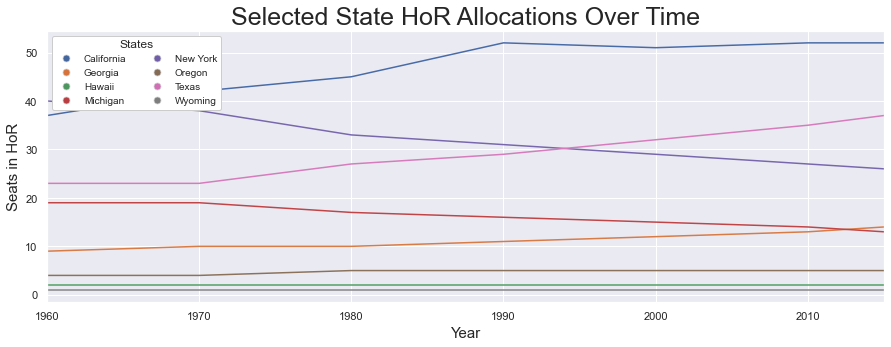

In [21]:
ax = pltviz.comp_line(df=df_selected, 
                      dependent_cols='hor_allocation', 
                      indep_stats='year',
                      group_col='sub_lctn')

colors = [utils.rgb_to_hex(c) for c in sns.color_palette(n_colors=len(selected_states), desat=1)]
handles = pltviz.legend.gen_handles(colors=colors, size=7, marker='o')
labels = list(df_selected['sub_lctn'].unique())

ax.legend(handles=handles, labels=labels, 
          title='States',
          bbox_to_anchor=(0, 1),
          ncol=2, loc='upper left', fontsize=10, 
          title_fontsize=12, 
          frameon=True, facecolor='#ffffff', framealpha=1)

ax.axes.set_title('Selected State HoR Allocations Over Time', fontsize=25)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Seats in HoR', fontsize=15)

plt.show()

## Effects on Presidential Representation

As the seats in the HoR determine the votes that a state has for President in the Electoral College, let's further analyze this. Electoral College votes are calculated by adding the state's representation in the HoR and in the senate (two senators per state). We'll calculate the presidential votes for each state for all years, and then graph the population per Electoral College vote for the selected states over time:

In [22]:
df_new_states['ec_votes'] = df_new_states['hor_allocation'] + 2
df_new_states['pop_per_ecv'] = df_new_states['population'] / df_new_states['ec_votes']

In [23]:
df_new_states[df_new_states['sub_lctn'] == 'California']

,location,sub_lctn,qid,year,population,hor_allocation,ec_votes,pop_per_ecv
14,United States of America,California,Q99,2015,39144818,52,54,724904.037037
15,United States of America,California,Q99,2010,37253956,52,54,689888.074074
16,United States of America,California,Q99,2000,33871648,51,53,639087.698113
17,United States of America,California,Q99,1990,29760021,52,54,551111.500000
18,United States of America,California,Q99,1980,23667902,45,47,503572.382979
19,United States of America,California,Q99,1970,19953134,42,44,453480.318182
20,United States of America,California,Q99,1960,15717204,37,39,403005.230769


In [24]:
df_selected = df_new_states[df_new_states['sub_lctn'].isin(selected_states)]

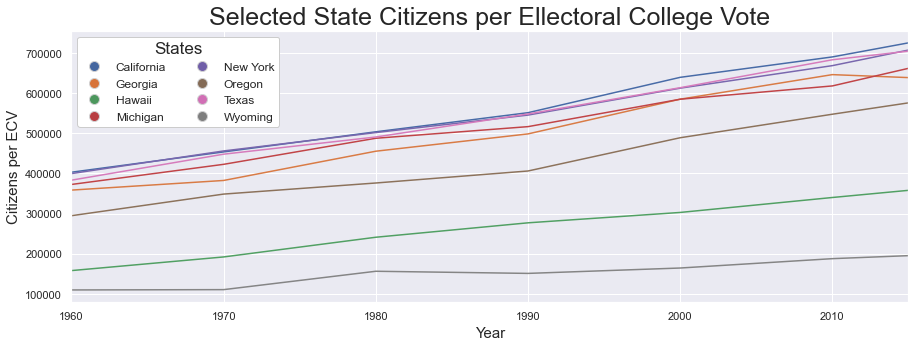

In [25]:
ax = pltviz.comp_line(df=df_selected, 
                      dependent_cols='pop_per_ecv', 
                      indep_stats='year',
                      group_col='sub_lctn')

colors = [utils.rgb_to_hex(c) for c in sns.color_palette(n_colors=len(selected_states), desat=1)]
handles = pltviz.legend.gen_handles(colors=colors, size=10, marker='o')
labels = list(df_selected['sub_lctn'].unique())

ax.legend(handles=handles, labels=labels, 
          title='States',
          bbox_to_anchor=(0, 1),
          ncol=2, loc='upper left', fontsize=12, 
          title_fontsize=17, 
          frameon=True, facecolor='#ffffff', framealpha=1)

ax.axes.set_title('Selected State Citizens per Ellectoral College Vote', fontsize=25)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Citizens per ECV', fontsize=15)

plt.show()

## Disproportionality

Let's close by calculating the disproportionality of the 2015 Electoral College votes as opposed to that of the 2015 allocations for seats in the House of Representatives. The measure of disproportionality we'll use is the [Gallagher index](https://en.wikipedia.org/wiki/Gallagher_index), which is similar to sum of squared residuals between shares and allocations. The typical settings for its use are deriving the fairness of allocations given either votes or populations in comparison to their resulting representations. The equation is as follows:

$$LSq = \sqrt{\frac{1}{2}\sum_{i=1}^{n}(S_i - A_i)^2}$$

with $S_i$ and $A_i$ being the shares and allocations of group $i$ respectively. 

The indexes for the House of Representatives and Electoral College using 2015 population estimates are the following:

In [26]:
hor_dispr_2015 = appointment.metrics.dispr_index(shares=df_new_states[df_new_states['year'] == '2015']['population'].values, 
                                                 allocations=df_new_states[df_new_states['year'] == '2015']['hor_allocation'].values, 
                                                 metric_type='Gallagher')
hor_dispr_2015

0.003337488951836875

In [27]:
ec_dispr_2015 = appointment.metrics.dispr_index(shares=df_new_states[df_new_states['year'] == '2015']['population'].values, 
                                                allocations=df_new_states[df_new_states['year'] == '2015']['ec_votes'].values, 
                                                metric_type='Gallagher')
ec_dispr_2015

0.022726461450575

In [28]:
ec_dispr_2015 / hor_dispr_2015

6.809449193252578